如何验证方法的性能并比较与过往方法的优劣： 

（1）是否能够显著区分新颖和非新颖两个组别的论文   得带上年份的信息

（2）在特定指标下，看多少实际为新颖的论文能够被划分为新颖论文

（3）两种对应方法计算出来的指标得分间是否存在显著差异

所应用的统计方法上：

    回归分析、相关性分析、分布检验（检验两个样本是否来自于同一分布）

In [1]:
import logging
import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr, spearmanr, kendalltau
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class Logger(object):
    def __init__(self, filename, level='info'):
        level = logging.INFO if level == 'info' else logging.DEBUG
        self.logger = logging.getLogger(filename)
        self.logger.propagate = False
        self.logger.setLevel(level)  # 

        th = logging.FileHandler(filename, 'a')

        self.logger.addHandler(th)  # 

##### 加载合并后的数据

In [2]:
import pandas as pd

df_all = pd.read_excel('gold_standard/F1000/Plos_recom_tags.xlsx')
print(df_all.shape)
pos_plos_dois = []
pos_recom_label = ['hypothesis', 'new finding', 'novel drug target', 'technical advance']
# pos_recom_label = ['hypothesis']

for row in df_all.iterrows():
    for column in pos_recom_label:
        if row[1][column] != 0:
            pos_plos_dois.append(row[1]['Doi'])
            break

print(len(pos_plos_dois)/df_all.shape[0])

(5082, 11)
0.9173553719008265


In [3]:
dois = df_all['Doi'].tolist()
years = df_all['Year'].tolist()
doi_to_year = {dois[i]:years[i] for i in range(len(dois))}
neg_plos_dois = [x for x in dois if x not in pos_plos_dois]

print(len(pos_plos_dois))
print(len(neg_plos_dois))

4662
420


### 检验是否显著

In [ ]:
def check_groups_balanced(path, saved_path):
    log = Logger(saved_path)
    df = pd.read_csv(path)
    df_pos = df[df['Doi'].isin(pos_plos_dois)]
    df_neg = df[df['Doi'].isin(neg_plos_dois)]

    pos_grouped = df_pos.groupby('Year')
    neg_grouped = df_neg.groupby('Year')

    sampled_pos = pd.DataFrame()
    for year, neg_year_grouped in neg_grouped:
        sample_size = len(neg_year_grouped)

        pos_year_group = pos_grouped.get_group(year)
        sampled_pos_year = pos_year_group.sample(n=sample_size, random_state=2024)

        sampled_pos = pd.concat([sampled_pos, sampled_pos_year])

    sampled_pos = sampled_pos.reset_index(drop=True)
    df_pos = sampled_pos
    log.logger.info(f"The number of positive samples is: {len(df_pos)}")
    log.logger.info(f"The number of negative samples is: {len(df_neg)}\n")

    pos_uzzi_novelty = np.array(df_pos['Novelty'].tolist())
    neg_uzzi_novelty = np.array(df_neg['Novelty'].tolist())

    u_stat, p_value = mannwhitneyu(pos_uzzi_novelty, neg_uzzi_novelty, alternative='two-sided')

    log.logger.info(f"U-statistic: {u_stat}")
    log.logger.info(f"P-value: {p_value}\n")

    alpha = 0.05  # 设定显著性水平
    if p_value < alpha:
        log.logger.info("拒绝原假设，两个集合间有显著差异")
    else:
        log.logger.info("不能拒绝原假设，两个集合间没有显著差异")

    log.logger.info(np.average(pos_uzzi_novelty))
    log.logger.info(np.average(neg_uzzi_novelty))

In [6]:
root_path = 'base_data/overview/'
# saved_path = 'log/check_group'

# check_groups_balanced(os.path.join(root_path, 'uzzi_sec_merge_comb_filtered.csv'),
#                       os.path.join(saved_path, 'uzzi_sec_merge_comb_filtered_group_balance.txt'))

# check_groups_balanced(os.path.join(root_path, 'uzzi_sec_merge_sec_filtered.csv'),
#                       os.path.join(saved_path, 'uzzi_sec_merge_sec_filtered_group_balance.txt'))

# check_groups_balanced(os.path.join(root_path, 'wang_sec_filtered.csv'),
#                       os.path.join(saved_path, 'wang_sec_filtered_group_balance.txt'))

# check_groups_balanced(os.path.join(root_path, 'wang_filtered.csv'),
#                       os.path.join(saved_path, 'wang_filtered_group_balance.txt'))

# check_groups_balanced(os.path.join(root_path, 'uzzi_filtered.csv'),
#                       os.path.join(saved_path, 'uzzi_filtered_group_balance.txt'))

In [ ]:
# robustness check
root_path = 'base_data/overview/'
saved_path = 'log/chech_group/robust_check.txt'
log = Logger(saved_path)

log.logger.info("uzzi")
check_groups_balanced(os.path.join())

log.logger.info("uzzi_sec_merge_comb")


log.logger.info("uzzi_sec_merge_sec")


In [5]:
def check_groups_unbalanced(path, saved_path):
    log = Logger(saved_path)
    df = pd.read_csv(path)
    df_pos = df[df['Doi'].isin(pos_plos_dois)]
    df_neg = df[df['Doi'].isin(neg_plos_dois)]

    log.logger.info(f"The number of positive samples is: {len(df_pos)}")
    log.logger.info(f"The number of negative samples is: {len(df_neg)}\n")

    pos_uzzi_novelty = np.array(df_pos['Novelty'].tolist())
    neg_uzzi_novelty = np.array(df_neg['Novelty'].tolist())

    u_stat, p_value = mannwhitneyu(pos_uzzi_novelty, neg_uzzi_novelty, alternative='two-sided')

    log.logger.info(f"U-statistic: {u_stat}")
    log.logger.info(f"P-value: {p_value}\n")

    alpha = 0.05  # 设定显著性水平
    if p_value < alpha:
        log.logger.info("拒绝原假设，两个集合间有显著差异")
    else:
        log.logger.info("不能拒绝原假设，两个集合间没有显著差异")

    log.logger.info(np.average(pos_uzzi_novelty))
    log.logger.info(np.average(neg_uzzi_novelty))

In [6]:
root_path = 'base_data/overview/'
saved_path = 'log/check_group'

check_groups_unbalanced(os.path.join(root_path, 'uzzi_sec_merge_comb_filtered.csv'),
                      os.path.join(saved_path, 'uzzi_sec_merge_comb_filtered_group_unbalance.txt'))

check_groups_unbalanced(os.path.join(root_path, 'uzzi_sec_merge_sec_filtered.csv'),
                      os.path.join(saved_path, 'uzzi_sec_merge_sec_filtered_group_unbalance.txt'))

check_groups_unbalanced(os.path.join(root_path, 'wang_sec_filtered.csv'),
                      os.path.join(saved_path, 'wang_sec_filtered_group_unbalance.txt'))

check_groups_unbalanced(os.path.join(root_path, 'wang_filtered.csv'),
                      os.path.join(saved_path, 'wang_filtered_group_unbalance.txt'))

check_groups_unbalanced(os.path.join(root_path, 'uzzi_filtered.csv'),
                      os.path.join(saved_path, 'uzzi_filtered_group_unbalance.txt'))

### 看新颖论文在新颖分数更高的区间的占比

#### Semantic

In [24]:
import pandas as pd

path = '../mesh_semantic.csv'
df = pd.read_csv(path)
df_pos_novel = df[df['Doi'].isin(pos_plos_dois)]
df_pos_novel.shape

(4376, 3)

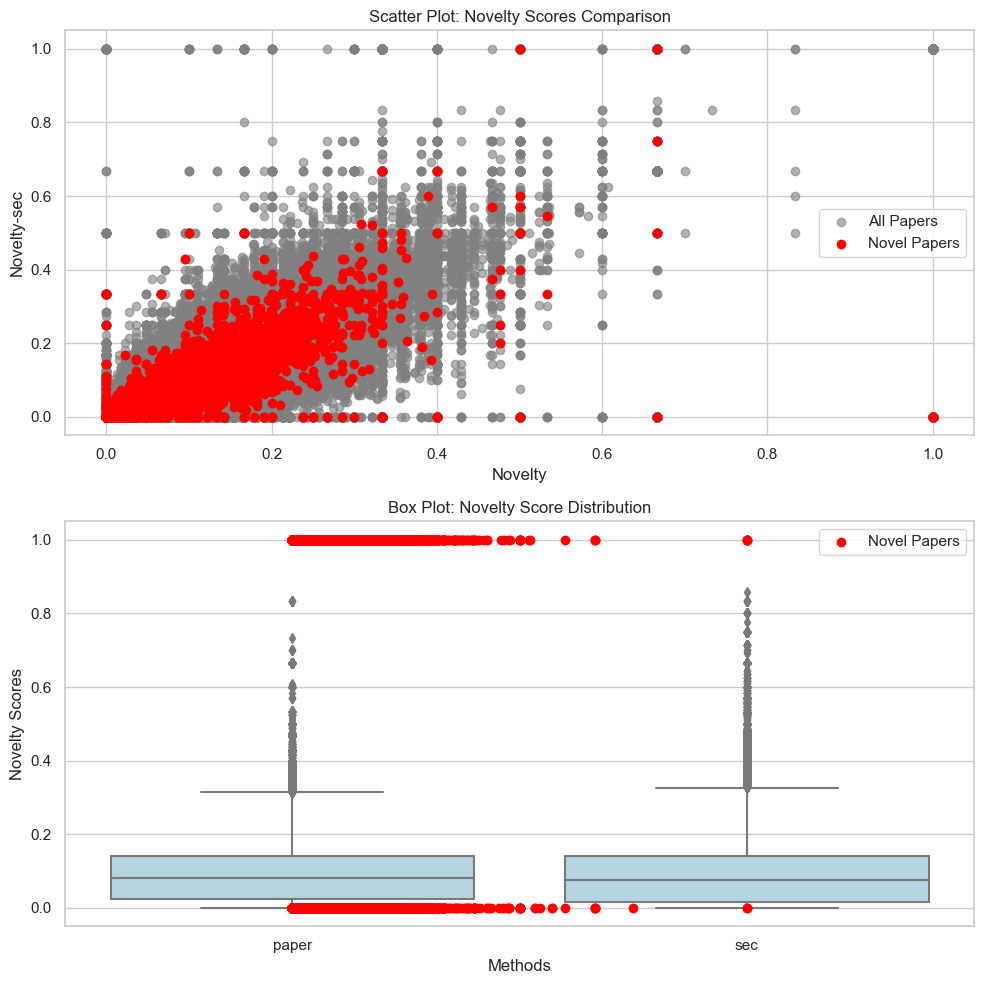

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个2行1列的图
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 1. 绘制散点图比较novel_1和novel_2分数
axes[0].scatter(df['paper'], df['sec'], color='gray', alpha=0.6, label="All Papers")
axes[0].scatter(df_pos_novel['paper'], df_pos_novel['sec'], color='red', label="Novel Papers")
axes[0].set_xlabel('Novelty')
axes[0].set_ylabel('Novelty-sec')
axes[0].set_title('Scatter Plot: Novelty Scores Comparison')
axes[0].legend()

# 2. 绘制novel_1和novel_2的箱线图
sns.boxplot(x="variable", y="value", data=pd.melt(df[['paper', 'sec']]), ax=axes[1], color='lightblue')
axes[1].scatter(df_pos_novel[['paper', 'sec']].stack().reset_index(drop=True), 
                [0] * len(df_pos_novel) + [1] * len(df_pos_novel), 
                color='red', label="Novel Papers", zorder=3)
axes[1].set_xlabel('Methods')
axes[1].set_ylabel('Novelty Scores')
axes[1].set_title('Box Plot: Novelty Score Distribution')
axes[1].legend()

# 调整布局
plt.tight_layout()
plt.show()

#### observe_vs_expect

In [26]:
import pandas as pd

path = '../mesh_observe_vs_expect.csv'
df = pd.read_csv(path)
df_pos_novel = df[df['Doi'].isin(pos_plos_dois)]
df_pos_novel.shape

(4344, 3)

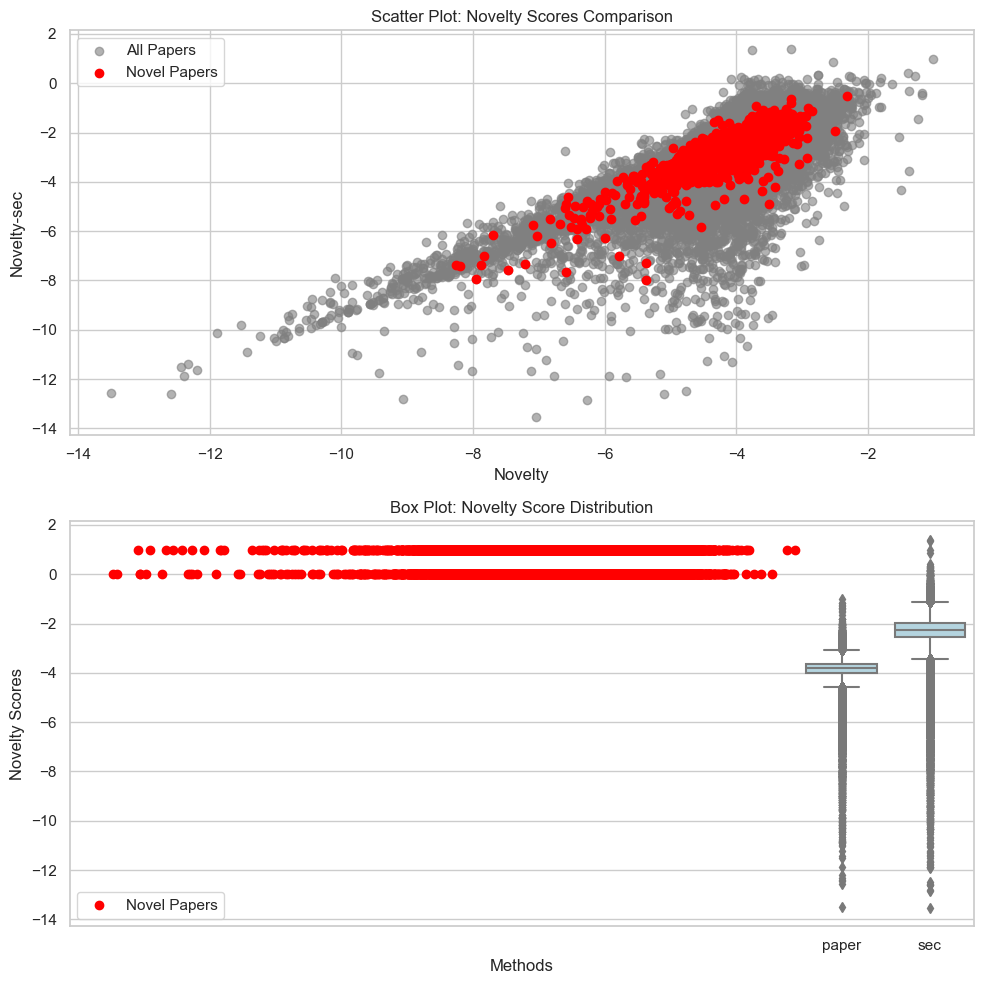

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")

# 创建一个2行1列的图
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 1. 绘制散点图比较novel_1和novel_2分数
axes[0].scatter(df['paper'], df['sec'], color='gray', alpha=0.6, label="All Papers")
axes[0].scatter(df_pos_novel['paper'], df_pos_novel['sec'], color='red', label="Novel Papers")
axes[0].set_xlabel('Novelty')
axes[0].set_ylabel('Novelty-sec')
axes[0].set_title('Scatter Plot: Novelty Scores Comparison')
axes[0].legend()

# 2. 绘制novel_1和novel_2的箱线图
sns.boxplot(x="variable", y="value", data=pd.melt(df[['paper', 'sec']]), ax=axes[1], color='lightblue')
axes[1].scatter(df_pos_novel[['paper', 'sec']].stack().reset_index(drop=True), 
                [0] * len(df_pos_novel) + [1] * len(df_pos_novel), 
                color='red', label="Novel Papers", zorder=3)
axes[1].set_xlabel('Methods')
axes[1].set_ylabel('Novelty Scores')
axes[1].set_title('Box Plot: Novelty Score Distribution')
axes[1].legend()

# 调整布局
plt.tight_layout()
plt.show()

### 考虑篇章前后指标得分的相关性

检验序列之间相关性的方法：
 
皮尔逊、斯皮尔曼、肯德尔相关系数；互信息

In [ ]:
def check_correlation(series_1, series_2, log_file):
    log_file.logger.info("pearsonr")
    pearsonr_coef, pearsonr_p_value = pearsonr(series_1, series_2)
    log_file.logger.info("pearsonr_coef: " + str(pearsonr_coef))
    log_file.logger.info("pearsonr_p_value: " + str(pearsonr_p_value))

    log_file.logger.info("spearmanr")
    spearmanr_coef, spearmanr_p_value = spearmanr(series_1, series_2)
    log_file.logger.info("spearmanr_coef: " + str(spearmanr_coef))
    log_file.logger.info("spearmanr_p_value: " + str(spearmanr_p_value))

    log_file.logger.info("kendalltau")
    kendalltau_coef, kendalltau_p_value = kendalltau(series_1, series_2)
    log_file.logger.info("kendalltau_coef: " + str(kendalltau_coef))
    log_file.logger.info("kendalltau_p_value: " + str(kendalltau_p_value))

In [ ]:
import pandas as pd

df_novel = pd.read_csv('../uzzi_novelty.csv')
ori_scores = df_novel['uzzi']
sec_scores = df_novel['uzzi_sec']
log = Logger('log/score_differ/uzzi.log')
check_correlation(ori_scores, sec_scores, log)

In [ ]:
df_novel = pd.read_csv("../wang_novelty.csv")
ori_scores = df_novel['wang']
sec_scores = df_novel['wang_sec']
log = Logger('log/score_differ/wang.log')
check_correlation(ori_scores, sec_scores, log)

In [8]:
df_novel = pd.read_csv("../mesh_cal_new.csv")
ori_scores = df_novel['paper']
sec_scores = df_novel['sec']
log = Logger('log/score_differ/mesh_cal_new.log')
check_correlation(ori_scores, sec_scores, log)

In [9]:
df_novel = pd.read_csv("../mesh_semantic.csv")
ori_scores = df_novel['paper']
sec_scores = df_novel['sec']
log = Logger('log/score_differ/mesh_semantic.log')
check_correlation(ori_scores, sec_scores, log)

In [10]:
df_novel = pd.read_csv("../mesh_observe_vs_expect.csv")
ori_scores = df_novel['paper']
sec_scores = df_novel['sec']
log = Logger('log/score_differ/mesh_observe_vs_expect.log')
check_correlation(ori_scores, sec_scores, log)

### 回归分析

#### 普通回归--以是否有新颖标签来作为二元因变量

In [1]:
def generate_balanced_file(path, saved_path):
    df = pd.read_csv(path)
    df_pos = df[df['Doi'].isin(pos_plos_dois)]
    df_neg = df[df['Doi'].isin(neg_plos_dois)]
    pos_grouped = df_pos.groupby('Year')
    neg_grouped = df_neg.groupby('Year')

    sampled_pos = pd.DataFrame()
    for year, neg_year_grouped in neg_grouped:
        sample_size = len(neg_year_grouped)

        pos_year_group = pos_grouped.get_group(year)
        sampled_pos_year = pos_year_group.sample(n=sample_size, random_state=2024)

        sampled_pos = pd.concat([sampled_pos, sampled_pos_year])

    sampled_pos = sampled_pos.reset_index(drop=True)
    df_pos = sampled_pos

    df_pos['label'] = [1 for i in range(len(df_pos))]
    df_neg['label'] = [0 for i in range(len(df_neg))]

    df = pd.concat([df_pos, df_neg], axis=0, ignore_index=True)
    df.to_excel(saved_path, index=False)

In [9]:
root_path = 'base_data/overview'
saved_path = 'gold_standard/regression'

# generate_balanced_file(os.path.join(root_path, 'uzzi_sec_merge_comb_filtered.csv'),
#                        os.path.join(saved_path, 'uzzi_sec_merge_comb_filtered_balanced.xlsx'))

generate_balanced_file(os.path.join(root_path, 'uzzi_sec_merge_sec_filtered.csv'),
                       os.path.join(saved_path, 'uzzi_sec_merge_sec_filtered_balanced.xlsx'))

# generate_balanced_file(os.path.join(root_path, 'wang_sec_filtered.csv'),
#                        os.path.join(saved_path, 'wang_sec_filtered_balanced.xlsx'))

# generate_balanced_file(os.path.join(root_path, 'wang_filtered.csv'),
#                        os.path.join(saved_path, 'wang_filtered_balanced.xlsx'))

# generate_balanced_file(os.path.join(root_path, 'uzzi_filtered.csv'),
#                        os.path.join(saved_path, 'uzzi_filtered_balanced.xlsx'))                

In [6]:
def generate_unbalanced_file(path, saved_path):
    df = pd.read_csv(path)
    df_pos = df[df['Doi'].isin(pos_plos_dois)]
    df_neg = df[df['Doi'].isin(neg_plos_dois)]

    df_pos['label'] = [1 for i in range(len(df_pos))]
    df_neg['label'] = [0 for i in range(len(df_neg))]

    df = pd.concat([df_pos, df_neg], axis=0, ignore_index=True)
    df.to_excel(saved_path, index=False)

In [10]:
root_path = 'base_data/overview'
saved_path = 'gold_standard/regression'

# generate_unbalanced_file(os.path.join(root_path, 'uzzi_sec_merge_comb_filtered.csv'),
#                        os.path.join(saved_path, 'uzzi_sec_merge_comb_filtered_unbalanced.xlsx'))

generate_unbalanced_file(os.path.join(root_path, 'uzzi_sec_merge_sec_filtered.csv'),
                       os.path.join(saved_path, 'uzzi_sec_merge_sec_filtered_unbalanced.xlsx'))

# generate_unbalanced_file(os.path.join(root_path, 'wang_sec_filtered.csv'),
#                        os.path.join(saved_path, 'wang_sec_filtered_unbalanced.xlsx'))

# generate_unbalanced_file(os.path.join(root_path, 'wang_filtered.csv'),
#                        os.path.join(saved_path, 'wang_filtered_unbalanced.xlsx')) 

# generate_unbalanced_file(os.path.join(root_path, 'uzzi_filtered.csv'),
#                        os.path.join(saved_path, 'uzzi_filtered_unbalanced.xlsx')) 

### 不同章节的新颖性与整体新颖性的关系

In [18]:
paper_specific_sec_novelty = None
with open("base_data/compare_specific_sec/uzzi_novelty_specific_sec.json", 'r') as f:
    paper_specific_sec_novelty = json.load(f)

sec_parts = ['introduction', 'results', 'discussion', 'method', 'conclusion']
sec_values = [[] for i in range(len(sec_parts))]

for item in paper_specific_sec_novelty.values():
    for i, sec in enumerate(sec_parts):
        if sec in item:
            sec_values[i].append(item[sec])
        else:
            sec_values[i].append(np.nan)

df_sec = pd.DataFrame()
df_sec['Doi'] = paper_specific_sec_novelty.keys()
for idx, sec in enumerate(sec_parts):
    df_sec[sec] = sec_values[idx]

df_sec.shape

(303759, 6)

In [ ]:
df_raw = pd.read_csv("base_data/overview/uzzi_filtered.csv")
df_merge_comb = pd.read_csv("base_data/overview/uzzi_sec_merge_comb_filtered.csv")
df_merge_sec = pd.read_csv("base_data/overview/uzzi_sec_merge_sec_filtered.csv")

In [31]:
def draw_correlation_sec_and_paper(df, df_sec):
    fig, axs = plt.subplots(2, 3, figsize=(12, 6))
    axs = axs.flatten()

    for idx, sec in enumerate(sec_parts):
        df_now = df_sec[['Doi', sec]]
        df_now = df_now.dropna()
        merged_df = pd.merge(df,df_now, on='Doi', suffixes=('_paper',f'_{sec}'), how='inner')

        series_1 = merged_df['Novelty'].tolist()
        series_2 = merged_df[sec].tolist()

        axs[idx].scatter(series_1, series_2)
        axs[idx].set_title(sec)
    
    fig.delaxes(axs[-1])
    
    fig.tight_layout()
    fig.show()

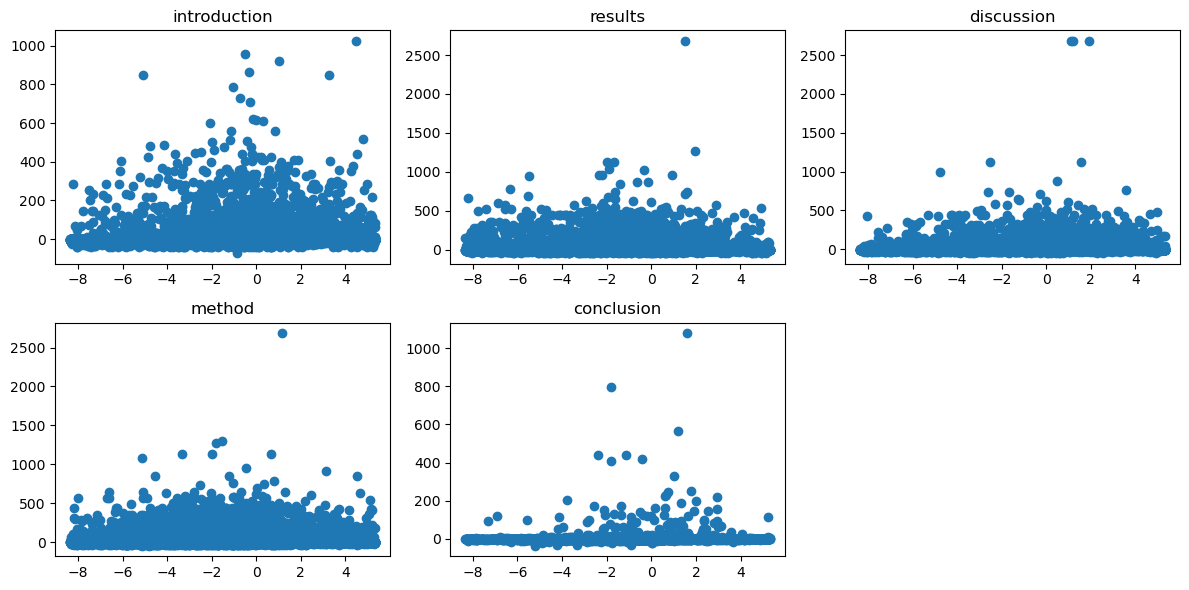

In [32]:
draw_correlation_sec_and_paper(df_raw, df_sec)

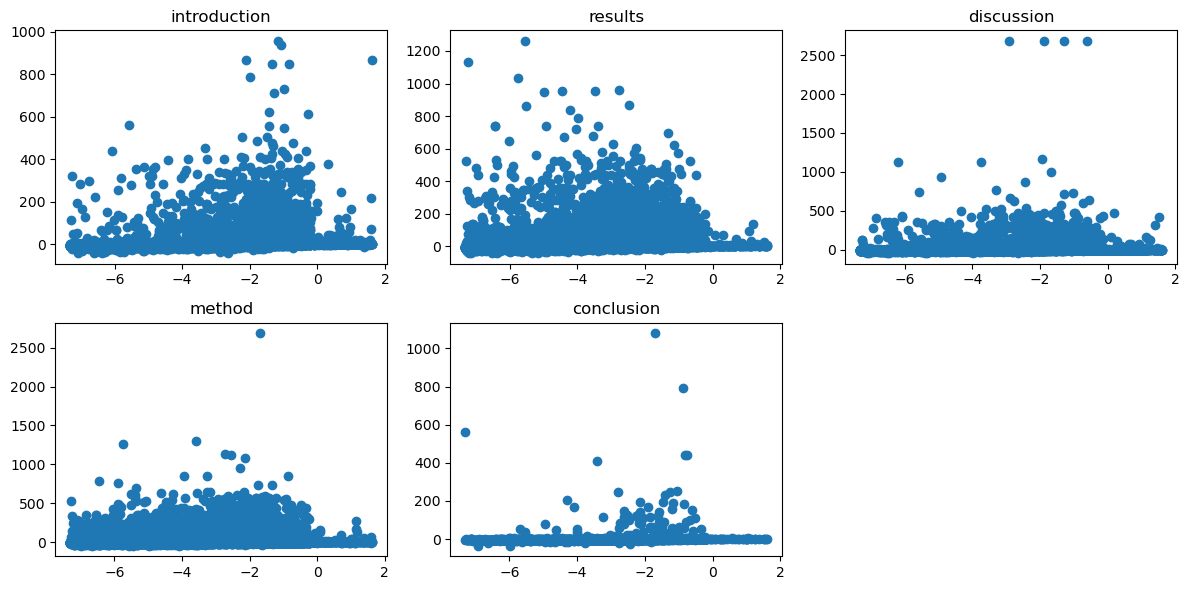

In [33]:
draw_correlation_sec_and_paper(df_merge_comb, df_sec)

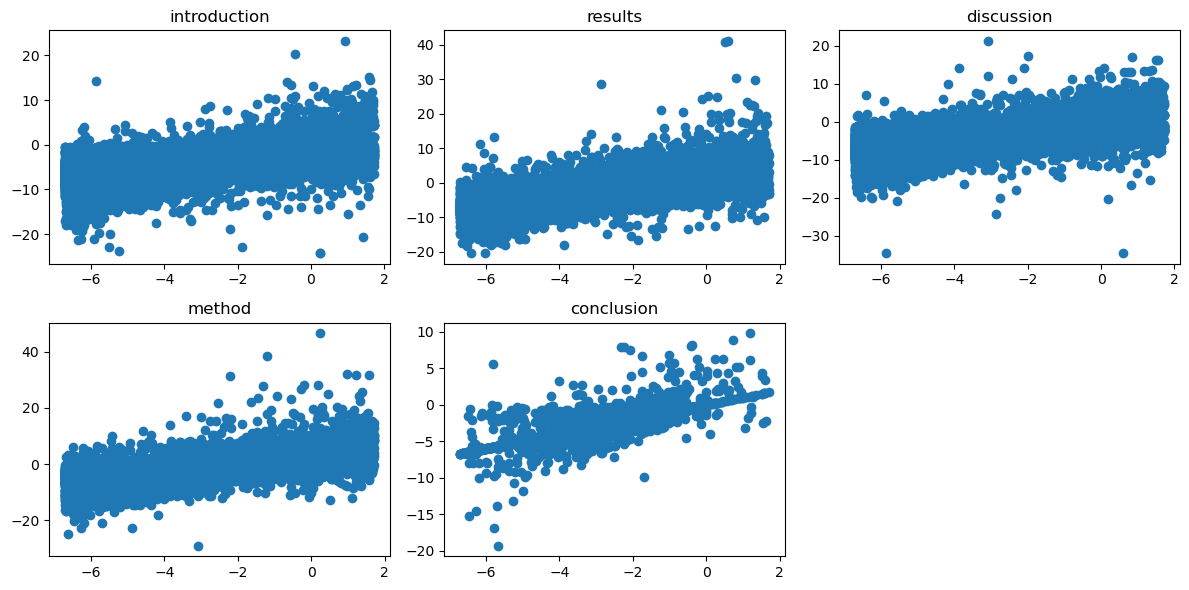

In [34]:
draw_correlation_sec_and_paper(df_merge_sec, df_sec)

In [19]:
def check_correlation_sec_and_paper(df, df_sec, path):
    log_file = Logger(path)
    for sec in sec_parts:
        df_now = df_sec[['Doi', sec]]
        df_now = df_now.dropna()
        merged_df = pd.merge(df,df_now, on='Doi', suffixes=('_paper',f'_{sec}'), how='inner')

        log_file.logger.info(f"{sec}\n")
        series_1 = merged_df['Novelty'].tolist()
        series_2 = merged_df[sec].tolist()
        
        pearsonr_coef, pearsonr_p_value = pearsonr(series_1, series_2)
        log_file.logger.info("pearsonr_coef: " + str(pearsonr_coef))
        log_file.logger.info("pearsonr_p_value: " + str(pearsonr_p_value))

        log_file.logger.info("spearmanr")
        spearmanr_coef, spearmanr_p_value = spearmanr(series_1, series_2)
        log_file.logger.info("spearmanr_coef: " + str(spearmanr_coef))
        log_file.logger.info("spearmanr_p_value: " + str(spearmanr_p_value))

        log_file.logger.info("kendalltau")
        kendalltau_coef, kendalltau_p_value = kendalltau(series_1, series_2)
        log_file.logger.info("kendalltau_coef: " + str(kendalltau_coef))
        log_file.logger.info("kendalltau_p_value: " + str(kendalltau_p_value))

In [ ]:
check_correlation_sec_and_paper(df_raw, df_sec, path='log/compare_sec/uzzi_filtered.txt')
check_correlation_sec_and_paper(df_merge_comb, df_sec, path='log/compare_sec/uzzi_sec_merge_comb_filtered.txt')
check_correlation_sec_and_paper(df_merge_sec, df_sec, path='log/compare_sec/uzzi_sec_merge_sec_filtered.txt')